# LBA: Grocery store prices
In this assignment, we model the cost of groceries in different parts of the world. To what extent do
grocery prices vary by country and store brand? Are grocery prices and the geographical
distribution of different grocery stores correlated with other cost-of-living measures- for example,
rent and real estate prices?

## Task 1: Prices
What is the basic average price for each product? You need to think carefully about how to
anchor the basic price for each product since this will depend on the currency used as well
as the distribution of prices.<br><br>

- Anchor in Euros
- Anchor at units that make sense for each category but is base 10 metric, e.g. milk in l, apples and potatoes in kg, meat and butter in 0.1kg. 

In [51]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pystan
import scipy.stats as stats

### Processing done before import
- changed country column to be standardized:
    - USA, UK, Germany (got rid of cities and alternative names for the countries)
    - Also change supermarket names to make sure the same market would have the same name there (e.g. 4 people went to the 4th street Trader Joe's)
- turned all rent prices into one number 
    - where necessary, looked up the price myself to be consistent in source within the city
    - San Francisco: https://www.zumper.com/blog/map-san-francisco-neighborhood-rent-prices-fall-2018/
    - Berlin: https://www.immobilienscout24.de/content/dam/is24/ibw/dokumente/mietmap_berlin_2020.jpg (this is the 2020 version of the 2016 map from the instructions)
    - London: https://maps.london.gov.uk/rents/ the official government map. I set it to 2 bedroom to approximate the Berlin one.
    - All other cities
        - took average where a range was given
        - converted to the country's currency where different unit was given
- sorted first by submitter then by country in excel
- exported to tsv to avoid commas in people's responses
- verified outliers with the authors, for example the 73GBP for bananas should be 0.73GBP
- used Mathematica to create a dictionary of conversion rates to EUR

In [2]:
# import the data
data = np.loadtxt("LBAData.tsv", delimiter="\t",dtype=object)
with open("conversions.json") as file:
    conversions = json.load(file)

In [3]:
#dimensions
print(np.shape(data))
#example datapoint
print(data[4])

(65, 68)
['10/30/2020 15:38:17' 'a.bricken@minerva.kgi.edu' 'Alexander Bricken'
 'Germany' 'EUR' 'EDEKA, Str. der Pariser Kommune 38, 10243 Berlin'
 'Mid-range' '915' '1' '3.42' '1' '3.55' '1' '4.44' '1' '0.86' '1' '1.95'
 '1' '1.95' '1' '3.42' '1' '3.89' '1' '4.88' '1' '0.58' '1' '0.58' '1'
 '1.69' '1' '1.34' '1' '0.97' '1' '0.87' '1' '7.4' '1' '6.5' '1' '7.81'
 '1' '1.65' '1' '0.76' '1' '1.05' '1' '8.6' '1' '8.9' '1' '9.2' '6' '1.56'
 '6' '1.75' '6' '2.44' '1' '7.45' '1' '9.8' '1' '8.25']


In [4]:
# make a dictionary to encode all the indexes
products = ['apples','bananas','tomatoes','potatoes','flour','rice','milk','butter','eggs','chicken']
indexes = {'country': 3,
          'currency': 4,
          'brand': 6,
          'rent': 7}

for no, prod in enumerate(products):
    for i in range (3):
        indexes[prod + str(i)] = 8+6*no+i*2
print(indexes)

{'country': 3, 'currency': 4, 'brand': 6, 'rent': 7, 'apples0': 8, 'apples1': 10, 'apples2': 12, 'bananas0': 14, 'bananas1': 16, 'bananas2': 18, 'tomatoes0': 20, 'tomatoes1': 22, 'tomatoes2': 24, 'potatoes0': 26, 'potatoes1': 28, 'potatoes2': 30, 'flour0': 32, 'flour1': 34, 'flour2': 36, 'rice0': 38, 'rice1': 40, 'rice2': 42, 'milk0': 44, 'milk1': 46, 'milk2': 48, 'butter0': 50, 'butter1': 52, 'butter2': 54, 'eggs0': 56, 'eggs1': 58, 'eggs2': 60, 'chicken0': 62, 'chicken1': 64, 'chicken2': 66}


In [5]:
# show all the quantities for one product
data[:,indexes['bananas0']]

array(['Product 1 quantity (kg)', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1.36078', '1.36078', '1', '1', '1', '1', '3.5', '1', '1',
       '0.118', '0.118', '1', '1', '0.54', '1', '0.6', '0.6', '1', '1',
       '0.78', '0.9', '1', '1', '0.453592', '0.453592', '0.2', '0.12',
       '1.3608', '0.4536', '1', '0.118', '0.45', '0.45', '0.45', '1',
       '0.91', '0.118', '0.4535924', '0.453592', '1', '1', '0.5'],
      dtype=object)

In [25]:
# write a function that normalizes by target unit and converts the currency
def get_normalized_price(i, target_unit):
    units = np.array([1 if x=="" else x for x in data[1:,i]], dtype=np.float)
    price = np.array([0 if x=="" else x for x in data[1:,i+1]], dtype=np.float)
    normalized_price = price/units*target_unit
    normalized_price_EUR = []
    for no, x  in enumerate(normalized_price):
        normalized_price_EUR.append( x*conversions[str(data[no+1,indexes['currency']])] )
    return normalized_price_EUR

In [27]:
apples = np.transpose([get_normalized_price(indexes['apples0'],1),
           get_normalized_price(indexes['apples1'],1),
           get_normalized_price(indexes['apples2'],1)])
bananas = np.transpose([get_normalized_price(indexes['bananas0'],1),
           get_normalized_price(indexes['bananas1'],1),
           get_normalized_price(indexes['bananas2'],1)])
tomatoes = np.transpose([get_normalized_price(indexes['tomatoes0'],1),
           get_normalized_price(indexes['tomatoes1'],1),
           get_normalized_price(indexes['tomatoes2'],1)])
potatoes = np.transpose([get_normalized_price(indexes['potatoes0'],1),
           get_normalized_price(indexes['potatoes1'],1),
           get_normalized_price(indexes['potatoes2'],1)])
flour = np.transpose([get_normalized_price(indexes['flour0'],1),
           get_normalized_price(indexes['flour1'],1),
           get_normalized_price(indexes['flour2'],1)])
rice = np.transpose([get_normalized_price(indexes['rice0'],1),
           get_normalized_price(indexes['rice1'],1),
           get_normalized_price(indexes['rice2'],1)])
milk = np.transpose([get_normalized_price(indexes['milk0'],1),
           get_normalized_price(indexes['milk1'],1),
           get_normalized_price(indexes['milk2'],1)])
# measure butter in 100g
butter = np.transpose([get_normalized_price(indexes['butter0'],0.1),
           get_normalized_price(indexes['butter1'],0.25),
           get_normalized_price(indexes['butter2'],0.25)])
# get 10 eggs, the common unit in Germany (so EUR)
eggs = np.transpose([get_normalized_price(indexes['eggs0'],10),
           get_normalized_price(indexes['eggs1'],10),
           get_normalized_price(indexes['eggs2'],10)])
# measure butter in 100g
chicken = np.transpose([get_normalized_price(indexes['chicken0'],0.1),
           get_normalized_price(indexes['chicken1'],0.1),
           get_normalized_price(indexes['chicken2'],0.1)])

In [29]:
# also adjust the rent prices by country currency
rent = []
for no, x in enumerate(data[1:,indexes['rent']]):
    x = x.replace(',','')
    x = float(x.replace('$',''))
    new_price = x*conversions[str(data[no+1,indexes['currency']])]
    rent.append(new_price)

In [55]:
brand_code = {'Budget (cheap)': 1,'Mid-range': 2, 'Luxury (expensive)': 3}
country_code = {'Germany': 1, 'Guatemala': 2, 'Morocco': 3, 'South Korea': 4, 'UK': 5, 'USA': 6, 'Vietnam': 7}

In [77]:
# dictionary to encode the brand perception
# create a list of three lists representing the price, brand perception and country
def make_data_set(product):
    price = []
    brand = []
    country = []
    for i, x in enumerate(product):
        for p in x:
            if p != 0:
                price.append(p)
                brand.append(brand_code[data[i+1,indexes['brand']]])
                country.append(country_code[data[i+1,indexes['country']]])
    return np.array([price,brand,country])

In [78]:
banana_data = make_data_set(bananas)

In [47]:
# group the rent by country
rent_by_country = {}
for i, x in enumerate(rent):
    if data[i+1,indexes['country']] in rent_by_country.keys() and x != 0:
        rent_by_country[data[i+1,indexes['country']]].append(x)
    elif x != 0:
        rent_by_country[data[i+1,indexes['country']]] = [x]

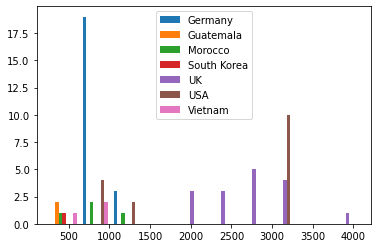

In [49]:
countries = list(rent_by_country.keys())
by_country_list = [rent_by_country[key] for key in countries]
plt.hist(by_country_list, histtype='bar', label=countries)
plt.legend(prop={'size': 10})
plt.show()

## Task 2: Factors influencing prices
How much does each of the following factors modify the basic price of the product (up or
down)?
- The geographical location (country) of the grocery store.
- Brand of the grocery store. Since we are getting data from multiple countries, you will need to specify whether the store brand is considered budget (cheap), mid-range, or luxury (expensive). This should be based on what you think the general public perception of the store brand is.
- Does price variation by geographical location correlate with variation in rental prices, or
not?

Explain in your report how strong each of these effects is. Which has the greatest influence
on price variation between shops?

Notes:
- Two levels of categorical variables
    - country
    - grocery store rating
- one numeric variable: rent price
- Determine significance and size of the variation between categories

# Model
You are encouraged to use the model structure described below for this assignment. However, you
may modify the model if you have ideas on how to improve it. If you do decide to modify the model,
you have to do so in a way that still allows you to address all points in the Questions to Answer section above. 
You should also motivate any changes to the model.<br>
Implement your model in PyStan, generate samples from the posterior, present your posterior
results, and use your posteriors to answer the questions provided.<br>
The basic idea of the model is that each type of product (apples, bananas, etc.) has a base price,
with multipliers depending on store brand and geographical location.<br>
- The base price of each product.
    - Price is a positive real number.
    - It is up to you to choose a good prior.
- The multiplier for each store type (budget/mid-range/luxury).
    - This is a scale parameter (positive real number).
    - The prior can be centered on 1, to achieve an average multiplier of 1. This would make the base price (approximately) match the average price in mid-range stores.
- The multiplier for the country or state.
    - This is a scale parameter (positive real number).
    - The prior should also be centered on 1. Expensive countries/states will have multipliers above 1 and inexpensive countries will have multipliers below 1.<br>

For example,
-  The base price of 1 liter of full cream milk might be 0.70 ¼.
-  ALDI stores are considered inexpensive and might be only 0.9 times as expensive as the average store.
- Stores in Germany might be 1.4 times more expensive than stores in the average country or state.
So as a result, 1 liter of full cream milk in an ALDI store in Berlin should cost about 0.70 * 0.9 *
1.4 = 0.88  with some random variation around that value.

In [99]:
# define the data for the stan model
stan_data = {
    'bananas': {
        'n': len(banana_data[0]),
        'prices': banana_data[0],
        # 1 for cheap, 2 for mid-range, 3 for expensive
        'n_brands' : 3,
        'brand' : banana_data[1],
        # by alphabet [Germany:1, Guatemala:2, Morocco: 3, South Korea: 4, UK:5, USA:6, Vietnam:7]
        'n_countries' : 7,
        'country' : banana_data[2],
    }
}

In [94]:
# define stan code
stan_code = """
// All known quanitites
data {  
    int<lower=1> n; // number of data points
    real<lower=0> prices[n]; // the data points of prices
    int<lower=1> n_brands; // number of brand categories (3)
    int<lower=1> n_countries; // number of countries (7)
    int<lower=0> brand[n]; // the brand perception for each data point
    int<lower=0> country[n]; // the country for each data point
}

// All unknown quantities
parameters {
    real<lower=0> average_price; // the main goal, our average price
    real<lower=0> sigma; // variance around our price
    real<lower=0> brand_multiplier[n_brands];  // multiplier for the type of store
    real<lower=0> country_multiplier[n_countries]; //multiplier for the 
}

// The model block contains all probability distributions in the model.
model {
    brand_multiplier[1] ~ uniform(0,1); // prior for cheap coefficient: between 0 and 1
    brand_multiplier[2] ~ uniform(1,1);    // prior for mid-range coefficient: 1
    brand_multiplier[3] ~ uniform(1,2);    // prior for expensive stores: between 1 and 2
    country_multiplier[n_countries] ~ uniform(0,2); // prior for coutnry coefficients
    for (t in 1:n){
        prices[t] ~ normal(average_price*brand_multiplier[brand[t]]*country_multiplier[country[t]],sigma);
        // likelihood
    };   
    }

"""
# define stan model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_371a34e74d5fdd1be986fec17c4c56c4 NOW.


In [100]:
stan_results = stan_model.sampling(data=stan_data['bananas'])
print(stan_results.stansummary(pars=['average_price'], probs=[0.01, 0.5, 0.99]))

RuntimeError: Exception: int variable contained non-int values; processing stage=data initialization; variable name=brand; base type=int  (in 'unknown file name' at line 8)
